# Aim of this document is to create a model find a cruise condition for the simplifeied model at differnt AoA, linearise the EoM about this point and extrapolate across all V's

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [2]:
# create instance of a simplified model parameters
p = dof2.Simplified2DofModel(inner_freq=2,inner_mass=4,mass_ratio=4)

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system (about a fixed cruise condition)

In [12]:
## cruise angle to linearise about
c_angle = -20

#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,50,201)
aoa = [0,2.5,5,7.5,10]

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(v):
    p.V.value = v[0]
    val = sM.deriv(0,[np.deg2rad(c_angle),0,v[1],0],p)
    return sum(np.array(val)**2)
    

for i in aoa:
    p.alpha_r.value = np.deg2rad(i)
    res = minimize(ToMinimise,[40,-0.006]).x
    df = df.append({'aoa' : i, 'v' : res[0],'eta':np.deg2rad(c_angle),'q1':res[1]} , ignore_index=True)
        
df

,v,aoa,eta,q1
0,0.000004,0.0,-0.349066,-0.031654
1,0.000033,2.5,-0.349066,-0.031654
2,46.109605,5.0,-0.349066,-0.004032
3,27.542311,7.5,-0.349066,-0.004032
4,21.528976,10.0,-0.349066,-0.004032


### Linearise the system about these fixed points

In [13]:
# create complete EoM
func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.alpha_r])

In [14]:
flutdfv2 = pd.DataFrame()
vs = np.linspace(0,50,201)

for i in range(0,len(df)):
    # get the fixed point
    lp = [df['eta'].iloc[i],0,df['q1'].iloc[i],0]
    aoa_lp = np.deg2rad(df['aoa'].iloc[i])
    for v in vs:    
        # get the jacobian evaluated at this point
        j_lp = func(v,aoa_lp,lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp)
        # populate test specific data   
        jac_dat['V'] = v
        jac_dat['aoa'] = np.round(np.rad2deg(aoa_lp),1)
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,Mode,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,V,aoa,lp
0,0,0.000000+13.472693j,2.220446e-16,13.472693,2.144246,6.123234e-17,False,"[(4.8348216577737e-17-0.0601831177361015j), (0...",0.00,0.0,"[-0.3490658503988659, 0, -0.031653916430630015..."
1,1,-1.299906+0.000000j,-1.299906e+00,0.000000,0.000000,NaN,False,"[(-0.6097373577683662+0j), (0.7926010387043767...",0.00,0.0,"[-0.3490658503988659, 0, -0.031653916430630015..."
2,2,1.299906+0.000000j,1.299906e+00,0.000000,0.000000,NaN,False,"[(0.6097373577683662+0j), (0.7926010387043767+...",0.00,0.0,"[-0.3490658503988659, 0, -0.031653916430630015..."
3,0,-0.002780+13.472678j,-2.779933e-03,13.472678,2.144243,-2.063386e-04,False,[(-1.2418192653388428e-05-0.06018357138147158j...,0.25,0.0,"[-0.3490658503988659, 0, -0.031653916430630015..."
4,1,1.280857+0.000000j,1.280857e+00,0.000000,0.000000,NaN,False,"[(-0.6153869607326767+0j), (-0.788222618888095...",0.25,0.0,"[-0.3490658503988659, 0, -0.031653916430630015..."
...,...,...,...,...,...,...,...,...,...,...,...
2164,1,1.074289+12.366772j,1.074289e+00,12.366772,1.975645,8.654310e-02,False,"[(0.006444597922516681-0.07418752595524657j), ...",49.50,10.0,"[-0.3490658503988659, 0, -0.004032183959581825..."
2165,0,-5.227059+12.186820j,-5.227059e+00,12.186820,2.110473,-3.941828e-01,False,"[(-0.029224126900914388-0.06813566467731424j),...",49.75,10.0,"[-0.3490658503988659, 0, -0.004032183959581825..."
2166,1,1.089088+12.377230j,1.089088e+00,12.377230,1.977509,8.765259e-02,False,"[(0.006517081323428154-0.07406509574351293j), ...",49.75,10.0,"[-0.3490658503988659, 0, -0.004032183959581825..."
2167,0,-5.262351+12.232494j,-5.262351e+00,12.232494,2.119369,-3.951785e-01,False,"[(0.029172664059840942+0.06781273529969227j), ...",50.00,10.0,"[-0.3490658503988659, 0, -0.004032183959581825..."


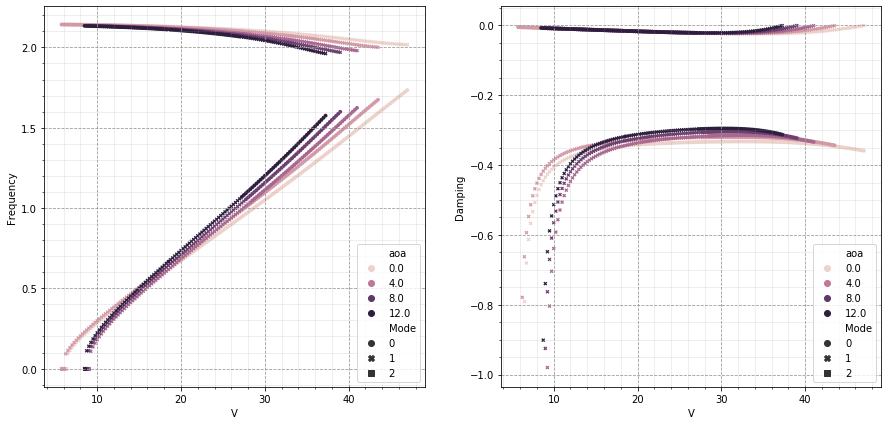

In [17]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0],s=15,edgecolor = 'none')
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1],s=15,edgecolor = 'none')
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [99]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0,ascending=False).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

,aoa,V,eta
368,2.5,43.25,-5.5
784,5.0,42.50,-5.5
1200,7.5,41.75,-5.5
1616,10.0,41.00,-5.5
